In [1]:
ROOT_DIR = "/home/user/Documents/projects/Metaworld"
%env MUJOCO_GL=egl

import sys
sys.path.append(ROOT_DIR)

import os
import functools
import json
from tqdm import tqdm
import importlib
from dataclasses import dataclass

# scientific
import cv2
import numpy as np
import torch
import pytorch_lightning as pl

# gym
# from gym.spaces import Box
import mujoco
import metaworld
from metaworld import MT1

# plotting
from PIL import Image
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from lightglue import viz2d

# project imports
# from metaworld.envs.mujoco.sawyer_xyz.test_scripted_policies import ALL_ENVS, test_cases_latest_nonoise
# import reset_space
import utils.camera_utils_v2 as cu
import keyframes.env_utils as env_utils
import keyframes.env_renderer as env_renderer
import keyframes.mujoco_utils as mujoco_utils
import keyframes.keyframe_utils as keyframe_utils
import keyframes.finetune_lightglue.pl_modules as pl_modules
import utils.predict_utils as keyframe_predict

import utils.slam_utils as slam_utils
import utils.depth_utils as depth_utils
import utils.match_utils as match_utils
import utils.transform_utils as transform_utils
import utils.inference_utils as inference_utils

import models.extern.mcc_model as mcc_model
import utils.mcc_misc_utils as mcc_misc_utils
import utils.mcc_data_utils as mcc_data_utils
import utils.predict_utils as predict_utils
import utils.vis_utils as vis_utils
import utils.plotly_utils as plotly_utils
from pytorch3d.io.obj_io import load_obj

import keyframes.policies.agent as agent
import keyframes.policies.pick_place_policy as pick_place_policy
import keyframes.policies.push_policy as push_policy
import keyframes.policies.pull_policy as pull_policy


from metaworld.policies.policy import Policy
from metaworld.envs.mujoco.sawyer_xyz.sawyer_xyz_env import (
    SawyerXYZEnv,
)
import metaworld.policies.sawyer_assembly_v2_policy as sawyer_assembly_v2_policy
import metaworld.policies.sawyer_handle_pull_side_v2_policy as sawyer_handle_pull_side_v2_policy

DEVICE = "cuda"


env: MUJOCO_GL=egl


In [2]:
importlib.reload(env_utils)

<module 'keyframes.env_utils' from '/home/user/Documents/projects/Metaworld/keyframes/env_utils.py'>

In [3]:
def go_forward(env: SawyerXYZEnv, renderer: env_renderer.EnvRenderer = None, agent: agent.Agent = None, n_steps=10):
    imgs = []
    o = env._prev_obs
    for i in range(n_steps):
        if agent is None:
            a = np.array([0,0,0,0])
        else:
            a = agent.get_action(o)
        #a = np.array([0,0.1,0,0])
        #print("action", a, o[:3])
        o, r, _, done, info = env.step(a)
        if done or info["success"] > 0:
            print("done", info["success"] > 0, i)
            break
        if renderer is not None:
            imgs.append(renderer.render()["img"].copy())
    records = {
        "imgs": imgs,
        "o": o,
        "r": r,
        "done": done,
        "info": info,
    }
    return records

In [4]:
import keyframes.reset_space as reset_space

In [233]:
importlib.reload(pull_policy)

<module 'keyframes.policies.pull_policy' from '/home/user/Documents/projects/Metaworld/keyframes/policies/pull_policy.py'>

In [249]:
# construct environment
env_index = 19
print(env_utils.env_names[env_index])
img_height, img_width = 360, 480
env, expert_policy, renderer = env_utils.generate_env_and_renderer(env_index, height=img_height, width=img_width, camera_name="topview")
T_world2pixel = cu.get_camera_transform_matrix(env, "topview", img_height, img_width)
T_pixel2world = np.linalg.inv(T_world2pixel)
env.reset()
o = go_forward(env, n_steps=100)["o"]

drawer-open-v2


In [250]:
# get grasp and target pos from the environment

# grasp_pos = env.obj_init_pos
# target_pos = env._target_pos

def get_policy(env, env_name, o):
   metaworld_policy = env_utils.policies[env_name]
   o_d = metaworld_policy._parse_obs(o)
   if env_name == "assembly-v2":
      pos_wrench = o_d["wrench_pos"] + np.array([-0.02, 0.0, 0.0])
      pos_peg = o_d["peg_pos"] + np.array([0.12, 0.0, 0.14])
      grasp_pos = pos_wrench + np.array([0.0, 0.0, 0.05]) # + np.array([0.0, 0.0, 0.1])
      # target_pos = pos_peg + np.array([0.0, 0.0, -0.1])
      target_pos = env._target_pos + np.array([0.1, 0.0, 0.05])
      return pick_place_policy.PickPlacePolicy(grasp_pos, target_pos)
   if env_name == 'basketball-v2':
      pos_ball = o_d["ball_pos"] + np.array([0.0, 0.0, 0.05])
      # X is given by hoop_pos
      # Y varies between .85 and .9, so we take avg
      # Z is constant at .35
      # pos_hoop = np.array([o_d["hoop_x"], *o_d["hoop_yz"]]) + np.array([-0.0, -0.03, 0.05])
      target_pos = env._target_pos + np.array([0.0, 0.0, 0.05])
      return pick_place_policy.PickPlacePolicy(pos_ball, target_pos)
   if env_name == 'bin-picking-v2':
      pos_cube = o_d["cube_pos"] + np.array([0.0, 0.0, 0.05])
      target_pos = env._target_pos + np.array([0.0, 0.0, 0.05])
      # NOTE we ignore the following and place the cube further away from the edge
      # This forces the scripted policy to pretend like the cube is located
      # more centrally in the bin (in Y direction). When the fingers close,
      # they'll drag the cube so that it's no longer located near an edge.
      # This ensures that the fingers don't get caught outside of the bin.
      # pos_cube[1] = max(0.675, min(pos_cube[1], 0.725))
      print("pos_cube", pos_cube, "target_pos", target_pos)
      return pick_place_policy.PickPlacePolicy(pos_cube, target_pos)
   if env_name == 'box-close-v2':
      grasp_pos = o_d["lid_pos"] + np.array([0.0, 0.0, 0.17])
      target_pos = env._target_pos.copy() + np.array([0.0, 0.0, 0.05])  # np.array([*o_d["box_pos"], 0.15]) + np.array([0.0, 0.0, 0.05])
      return pick_place_policy.PickPlacePolicy(grasp_pos, target_pos)
   if env_name == 'button-press-topdown-v2':
      push_start_pos = o_d["button_pos"] + np.array([0.0, 0.0, 0.05])
      target_pos = push_start_pos + np.array([0.0, 0.0, -0.2])
      return push_policy.PushPolicy(push_start_pos, target_pos)
   if env_name == 'button-press-topdown-wall-v2':
      push_start_pos = o_d["button_pos"] + np.array([0.0, 0.0, 0.05])
      target_pos = push_start_pos + np.array([0.0, 0.0, -0.2])
      return push_policy.PushPolicy(push_start_pos, target_pos)
   if env_name == 'button-press-v2':
      push_start_pos = o_d["button_pos"] + np.array([0.0, -0.05, 0.0])
      target_pos = push_start_pos + np.array([0.0, 0.1, 0.0])
      return push_policy.PushPolicy(push_start_pos, target_pos)
   if env_name == 'button-press-wall-v2':
      push_start_pos = o_d["button_pos"] + np.array([0.0, -0.05, 0.0])
      target_pos = push_start_pos + np.array([0.0, 0.1, 0.0])
      return push_policy.PushPolicy(push_start_pos, target_pos)
   if env_name == 'coffee-button-v2':
      push_start_pos = o_d["button_pos"] + np.array([0.0, 0.0, -0.07])
      target_pos = o_d["button_pos"] + np.array([0.0, 0.0, 0.2])
      return push_policy.PushPolicy(push_start_pos, target_pos)
   if env_name == 'coffee-pull-v2':
      grasp_pos = o_d["mug_pos"] + np.array([-0.005, 0.0, 0.1])
      # TODO why is target_pos not the same as in the environment?
      # target_pos = o_d["target_pos"] + np.array([0.0, 0.0, 0.05])
      target_pos = env._target_pos + np.array([0.0, 0.0, 0.05])
      return pick_place_policy.PickPlacePolicy(grasp_pos, target_pos)
   if env_name == 'coffee-push-v2':
      grasp_pos = o_d["mug_pos"] + np.array([-0.005, 0.0, 0.1])
      target_pos = env._target_pos + np.array([0.0, 0.0, 0.05])
      return pick_place_policy.PickPlacePolicy(grasp_pos, target_pos)
   if env_name == 'dial-turn-v2':
      pass
   if env_name == 'disassemble-v2':
      # NOTE this should be pull instead of pick and place
      pos_wrench = o_d["wrench_pos"] + np.array([-0.02, 0.0, 0.0])
      # pos_peg = o_d["peg_pos"] + np.array([0.12, 0.0, 0.14])
      pull_start_pos = pos_wrench + np.array([0.0, 0.0, -0.07]) # + np.array([0.0, 0.0, 0.1])
      # target_pos = pos_peg + np.array([0.0, 0.0, -0.1])
      pull_goal_pos = pull_start_pos + np.array([0.0, 0.0, 0.5])
      return pull_policy.PullPolicy(pull_start_pos, pull_goal_pos)
   if env_name == 'door-close-v2':
      pass
   if env_name == 'door-lock-v2':
      pass
   if env_name == 'door-open-v2':
      pass
   if env_name == 'door-unlock-v2':
      pass
   if env_name == 'hand-insert-v2':
      grasp_pos = o_d["obj_pos"] + np.array([0.0, 0.0, 0.05])
      target_pos = o_d["goal_pos"] + np.array([0.0, 0.0, 0.05])
      # NOTE works much better if target_pos z is greater than 0.05
      # target_pos[2] = np.max([target_pos[2], 0.05])
      return pick_place_policy.PickPlacePolicy(grasp_pos, target_pos)
   if env_name == 'drawer-close-v2':
      push_start_pos = o_d["drwr_pos"] + np.array([0.0, -0.1, 0.00])
      target_pos = push_start_pos + np.array([0.0, 0.2, 0.0])
      return push_policy.PushPolicy(push_start_pos, target_pos)
   if env_name == 'drawer-open-v2':
      pull_start_pos = o_d["drwr_pos"] + np.array([0.0, -0.01, 0.00])
      pull_goal_pos = pull_start_pos + np.array([0.0, -0.5, 0.0])
      # return push_policy.PushPolicy(push_start_pos, target_pos)
      return pull_policy.PullPolicy(pull_start_pos, pull_goal_pos)
   if env_name == 'faucet-open-v2':
      pass
   if env_name == 'faucet-close-v2':
      pass
   if env_name == 'hammer-v2':
      pass
   if env_name == 'handle-press-side-v2':
      push_start_pos = o_d["handle_pos"] + np.array([0.0, 0.0, 0.2])
      target_pos = o_d["handle_pos"] + np.array([0.0, 0.0, -0.5])
      return push_policy.PushPolicy(push_start_pos, target_pos)
   if env_name == 'handle-press-v2':
      push_start_pos = o_d["handle_pos"] + np.array([0.0, 0.0, 0.2])
      target_pos = o_d["handle_pos"] + np.array([0.0, 0.0, -0.5])
      return push_policy.PushPolicy(push_start_pos, target_pos)
   if env_name == 'handle-pull-side-v2':
      pull_start_pos = o_d["handle_pos"] + np.array([0.0, 0.0, -0.07])
      pull_goal_pos = o_d["handle_pos"] + np.array([0.0, 0.0, 0.5])
      print("pull_start_pos", pull_start_pos, "pull_goal_pos", pull_goal_pos)
      return pull_policy.PullPolicy(pull_start_pos, pull_goal_pos)
      # return sawyer_handle_pull_side_v2_policy.SawyerHandlePullSideV2Policy()
   if env_name == 'handle-pull-v2':
      pull_start_pos = o_d["handle_pos"] + np.array([0.015, 0.0, -0.07])
      pull_goal_pos = pull_start_pos + np.array([0.0, 0.0, 0.5])
      print("pull_start_pos", pull_start_pos, "pull_goal_pos", pull_goal_pos)
      return pull_policy.PullPolicy(pull_start_pos, pull_goal_pos)
      pass
   if env_name == 'lever-pull-v2':
      pass
   if env_name == 'peg-insert-side-v2':
      pass
   if env_name == 'pick-place-wall-v2':
      grasp_pos = o_d["puck_pos"] + np.array([-0.0, 0.0, 0.05])
      # target_pos = o_d["goal_pos"] + np.array([0.0, 0.0, 0.05])
      target_pos = env._target_pos + np.array([0.0, 0.0, 0.05])
      return pick_place_policy.PickPlacePolicy(grasp_pos, target_pos)
   if env_name == 'pick-out-of-hole-v2':
      grasp_pos = o_d["puck_pos"] + np.array([-0.01, 0.0, 0.04])
      target_pos = o_d["goal_pos"] + np.array([0.0, 0.0, 0.05])
      return pick_place_policy.PickPlacePolicy(grasp_pos, target_pos)
   if env_name == 'reach-v2':
      # NOTE not a manipulation task
      pass
   if env_name == 'push-back-v2':
      grasp_pos = o_d["puck_pos"] + np.array([0.0, 0.0, 0.05])
      target_pos = o_d["goal_pos"] + np.array([0.0, 0.0, 0.05])
      return pick_place_policy.PickPlacePolicy(grasp_pos, target_pos)
   if env_name == 'push-v2':
      grasp_pos = o_d["puck_pos"] + np.array([-0.01, 0.0, 0.05])
      # target_pos = o_d["goal_pos"] + np.array([0.0, 0.0, 0.05])
      target_pos = env._target_pos + np.array([0.0, 0.0, 0.05])
      return pick_place_policy.PickPlacePolicy(grasp_pos, target_pos)
   if env_name == 'pick-place-v2':
      grasp_pos = o_d["puck_pos"] + np.array([-0.0, 0.0, 0.05])
      # target_pos = o_d["goal_pos"] + np.array([0.0, 0.0, 0.05])
      target_pos = env._target_pos + np.array([0.0, 0.0, 0.05])
      return pick_place_policy.PickPlacePolicy(grasp_pos, target_pos)
   if env_name == 'plate-slide-v2':
      pass
   if env_name == 'plate-slide-side-v2':
      pass
   if env_name == 'plate-slide-back-v2':
      pass
   if env_name == 'plate-slide-back-side-v2':
      pass
   if env_name == 'peg-unplug-side-v2':
      pos_peg = o_d["peg_pos"] + np.array([0.0, -0.01, 0.035])
      pull_start_pos = pos_peg + np.array([0.0, 0.0, -0.01])
      pull_goal_pos = pos_peg + np.array([0.04, 0.0, -0.01])
      return pull_policy.PullPolicy(pull_start_pos, pull_goal_pos)
   if env_name == 'soccer-v2':
      grasp_pos = o_d["ball_pos"] + np.array([0.0, 0.0, 0.05])
      target_pos = o_d["goal_pos"] + np.array([0.0, 0.0, 0.05])
      return pick_place_policy.PickPlacePolicy(grasp_pos, target_pos)
   if env_name == 'stick-push-v2':
      pass
   if env_name == 'stick-pull-v2':
      pass
   if env_name == 'push-wall-v2':
      grasp_pos = o_d["obj_pos"] + np.array([-0.0, 0.0, 0.05])
      # target_pos = o_d["goal_pos"] + np.array([0.0, 0.0, 0.05])
      target_pos = env._target_pos + np.array([0.0, 0.0, 0.05])
      return pick_place_policy.PickPlacePolicy(grasp_pos, target_pos)
   if env_name == 'reach-wall-v2':
      # NOTE not a manipulation task
      pass
   if env_name == 'shelf-place-v2':
      grasp_pos = o_d["block_pos"] + np.array([-0.005, 0.0, 0.05])
      target_pos = np.array([o_d["shelf_x"], *o_d["unused_3"]]) + np.array([0.0, 0.0, 0.05])
      return pick_place_policy.PickPlacePolicy(grasp_pos, target_pos)
   if env_name == 'sweep-into-v2':
      grasp_pos = o_d["cube_pos"] + np.array([-0.005, 0.0, 0.05])
      target_pos = o_d["goal_pos"] + np.array([0.0, 0.0, 0.05])
      return pick_place_policy.PickPlacePolicy(grasp_pos, target_pos)
   if env_name == 'sweep-v2':
      grasp_pos = o_d["cube_pos"] + np.array([-0.005, 0.0, 0.05])
      target_pos = o_d["goal_pos"] + np.array([0.0, 0.0, 0.05])
      return pick_place_policy.PickPlacePolicy(grasp_pos, target_pos)
   if env_name == 'window-open-v2':
      pos_wndw = o_d["wndw_pos"] + np.array([-0.03, -0.01, -0.08])
      push_start_pos = pos_wndw + np.array([-0.05, 0.0, 0.1])
      target_pos = pos_wndw + np.array([0.2, 0.0, 0.1])
      return push_policy.PushPolicy(push_start_pos, target_pos)
   if env_name == 'window-close-v2':
      pos_wndw = o_d["wndw_pos"] + np.array([-0.03, -0.0, -0.08])
      push_start_pos = pos_wndw + np.array([+0.05, -0.0, 0.15])
      target_pos = pos_wndw + np.array([-0.4, -0.03, 0.15])
      return push_policy.PushPolicy(push_start_pos, target_pos)


# agent
expert_agent = get_policy(env,env_utils.env_names[env_index], o)
expert_agent.log = True
expert_agent.log_level = 0

In [214]:
expert_agent.path_points[3].pos

array([0.10081226, 0.71999998, 0.09      ])

In [199]:
env.tcp_center

array([0.01973196, 0.40011659, 0.1512479 ])

In [187]:
env._goal_pos

AttributeError: 'SawyerDrawerOpenEnvV2' object has no attribute '_goal_pos'

('curr_path_point: 5, curr_path_point_done: False, action: [ 0.00120648 -0.35263211  0.00466425  0.6       ]',)
done True 0
[-0.23508827  0.57084442  0.08534833]


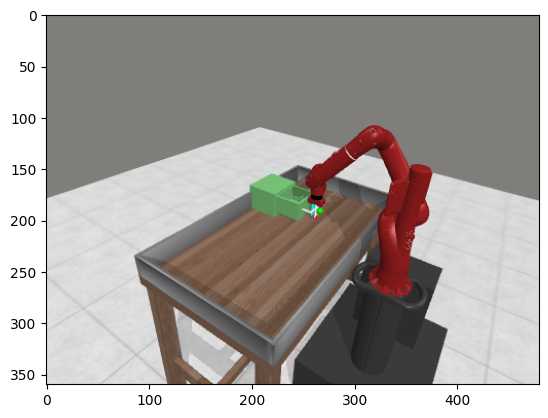

In [262]:
env.max_path_length = 1000
o = go_forward(env, agent = expert_agent, n_steps=20)["o"];
print(o[:3])
plt.imshow(cv2.flip(renderer.render(camera_name="corner2")["img"], 0))

In [29]:
env.reset()
go_forward(env, n_steps=100)["o"];

In [33]:
env.go_to_step(1)

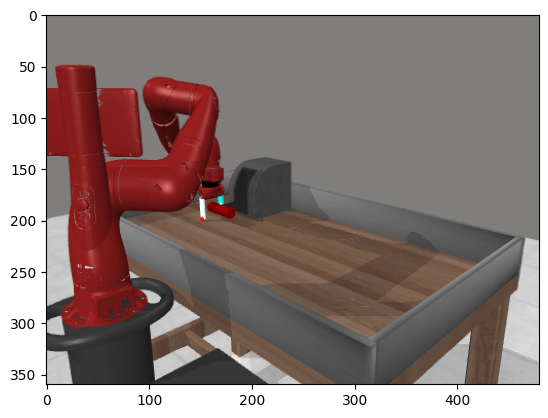

In [553]:
plt.imshow(cv2.flip(renderer.render(camera_name="corner")["img"], 0))

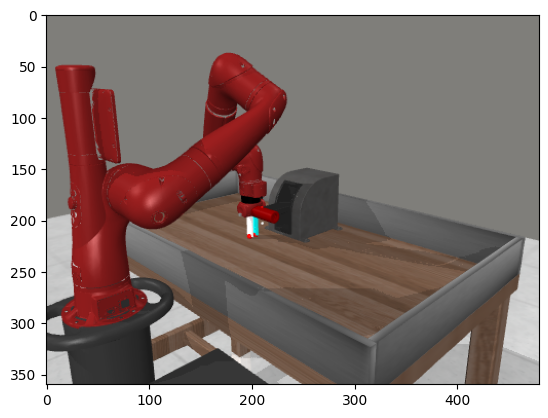

In [543]:
plt.imshow(cv2.flip(renderer.render(camera_name="corner")["img"], 0))

In [ ]:

if env_config is not None:
        o = init_env_from_config(env, env_config)
    else:
        env.reset()
        env.reset_model()
        o = env.reset()